# 50.038 Computational Data Science project

Group members:<br />Kenny Ong Ker Chin 1005290 <br />Jobelle Lee Ern Ee 1005547<br />Joe Baarath 1005433

## Problem

The problem is to predict the prices of public housing units in Singapore based on their characteristics. This will help potential buyers and sellers to make informed decisions about the market value of their properties.

## Dataset

The Housing and Development Board provides data on the resale price of the flats as well as relevant data that might impact these prices.<br />
Coverage of the data is from January 1, 2017 to March 5, 2023.<br />
The dataset includes information on the location, type, size, and age of the units. <a href='https://data.gov.sg/dataset/resale-flat-prices'>https://data.gov.sg/dataset/resale-flat-prices</a>

In [1]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("ticks")

# Resale Flat Prices data
url = "https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3"

<h1>Data Visualization</h1>

In [2]:
# Methods to get data from API
def searchData(url, keyword):
    results = pd.DataFrame()
    data = requests.get(f"{url}&q={keyword}").json()
    results.append(data['result']['records'])
    
    while data['result']['_links']['next']:
        data = requests.get("https://data.gov.sg/" + data['result']['_links']['next']).json()
        results.append(data['result']['records'])

    return results

def limitData(url, limitNum):
    data = requests.get(f"{url}&limit={limitNum}").json()
    return data['result']['records']


In [3]:
# Read data from csv file
df = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
df['year'] = df['month'].apply(lambda x: x.split('-')[0])
df['month'] = df['month'].apply(lambda x: x.split('-')[1])

# Convert remaining lease from years to months
df['month_remaining_lease'] = df['remaining_lease'].apply(lambda x: int(x.split(' ')[0]) * 12 + int(x.split(' ')[2]) if len(x.split(' ')) > 2 else int(x.split(' ')[0]) * 12)

# Split storey_range into 2 columns
df['storey_range_low'] = df['storey_range'].apply(lambda x: int(x.split(' TO ')[0]))
df['storey_range_high'] = df['storey_range'].apply(lambda x:int(x.split(' TO ')[1]))

df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_remaining_lease,storey_range_low,storey_range_high
0,01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,736,10,12
1,01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,727,1,3


In [4]:
df.town.value_counts()

SENGKANG           12478
PUNGGOL            10900
WOODLANDS          10306
YISHUN             10149
TAMPINES            9958
JURONG WEST         9818
BEDOK               7981
HOUGANG             7267
CHOA CHU KANG       6804
ANG MO KIO          6182
BUKIT MERAH         5680
BUKIT PANJANG       5672
BUKIT BATOK         4972
TOA PAYOH           4742
PASIR RIS           4567
KALLANG/WHAMPOA     4453
QUEENSTOWN          4211
GEYLANG             3675
SEMBAWANG           3671
CLEMENTI            3390
JURONG EAST         3086
BISHAN              2805
SERANGOON           2761
CENTRAL AREA        1236
MARINE PARADE        948
BUKIT TIMAH          386
Name: town, dtype: int64

                       floor_area_sqm  lease_commence_date  resale_price  \
floor_area_sqm               1.000000             0.135384      0.612471   
lease_commence_date          0.135384             1.000000      0.359414   
resale_price                 0.612471             0.359414      1.000000   
month_remaining_lease        0.139535             0.991760      0.330973   
storey_range_low            -0.011041             0.279173      0.365618   
storey_range_high           -0.011041             0.279173      0.365618   

                       month_remaining_lease  storey_range_low  \
floor_area_sqm                      0.139535         -0.011041   
lease_commence_date                 0.991760          0.279173   
resale_price                        0.330973          0.365618   
month_remaining_lease               1.000000          0.278313   
storey_range_low                    0.278313          1.000000   
storey_range_high                   0.278313          1.000000   

    

C:\Users\USER\AppData\Local\Temp\ipykernel_18516\2608089356.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
C:\Users\USER\AppData\Local\Temp\ipykernel_18516\2608089356.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

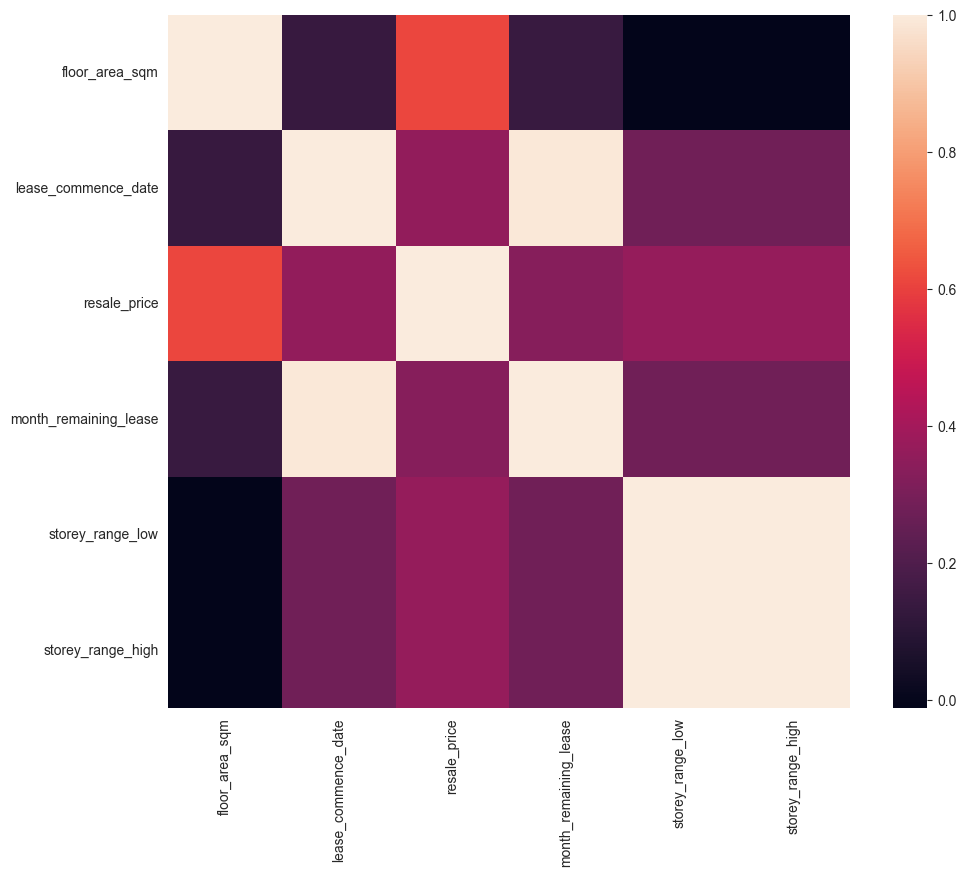

In [15]:
# Compute the correlation matrix
corr = df.corr()
print(corr)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(df.corr())

C:\Users\USER\AppData\Local\Temp\ipykernel_18516\169620486.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
C:\Users\USER\AppData\Local\Temp\ipykernel_18516\169620486.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)


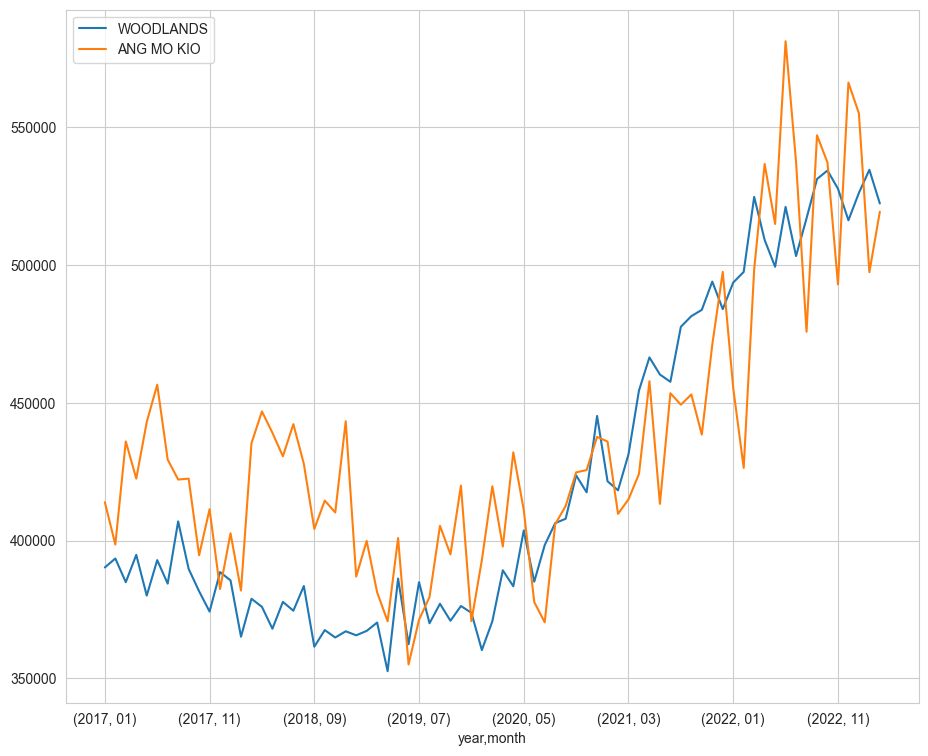

In [6]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(11, 9))

# for each month and year, plot the mean price into line chart with legend
def query_mean_plot_by_town(town):
    df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
    plt.legend()
    
query_mean_plot_by_town('WOODLANDS')
query_mean_plot_by_town('ANG MO KIO')

<Axes: title={'center': 'Town'}>

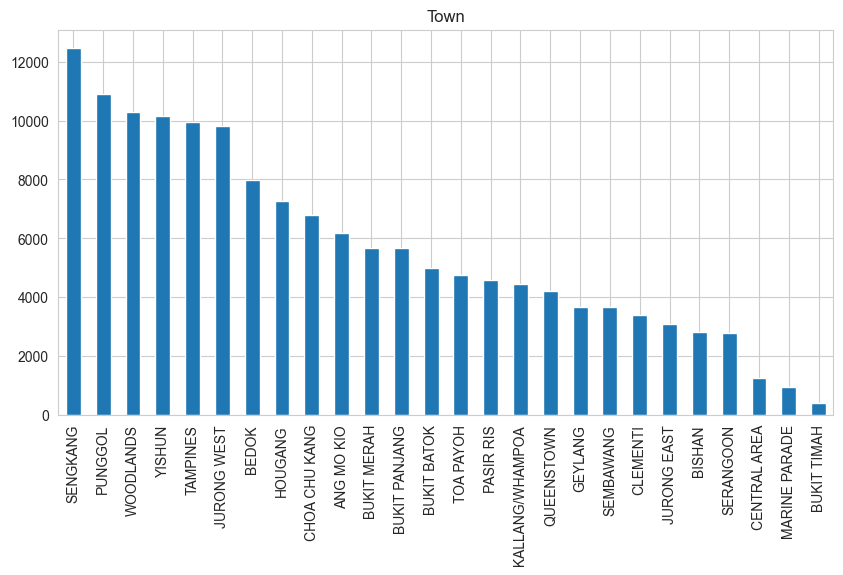

In [7]:
df.town.value_counts().plot(kind='bar', figsize=(10, 5), title='Town')

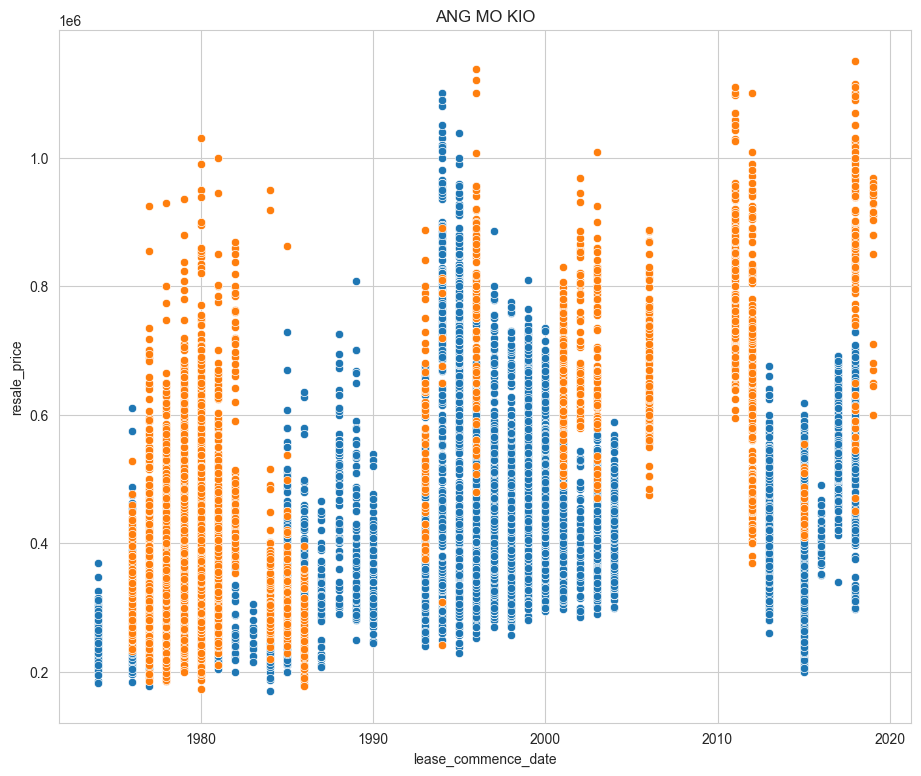

In [8]:
# For each town, plot lease_commence_date against resale price
f, ax = plt.subplots(figsize=(11, 9))
def plot_date_agst_price(town):
    sns.scatterplot(x='lease_commence_date', y='resale_price', data=df[df['town'] == town])
    plt.title(town)
    

plot_date_agst_price('WOODLANDS')
plot_date_agst_price('ANG MO KIO')

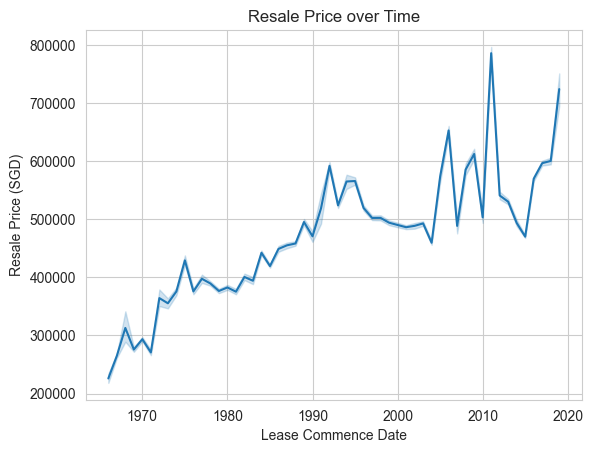

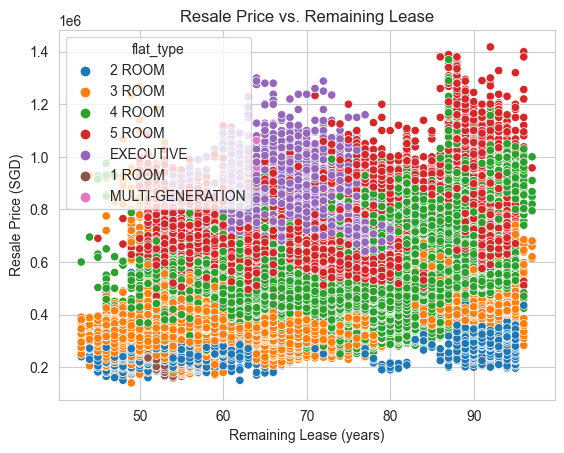

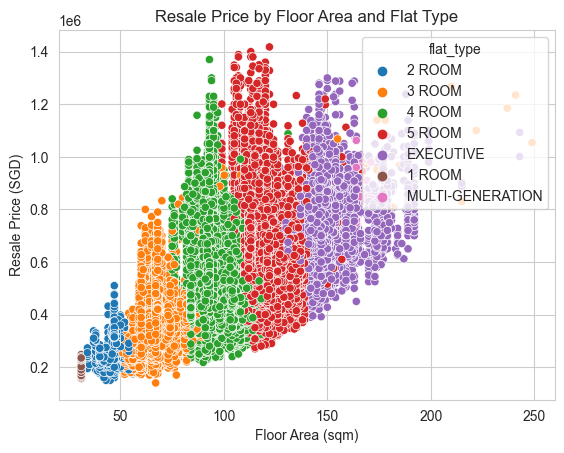

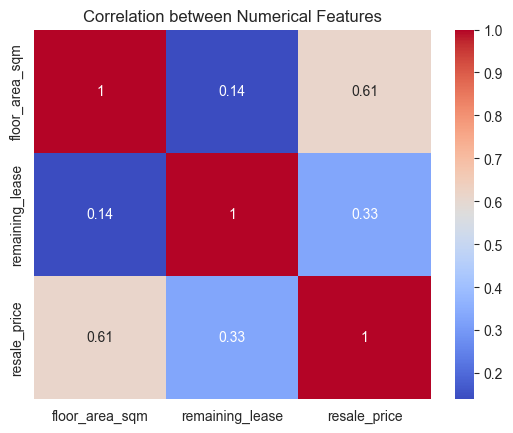

In [22]:
# line plot of lease commence date and resale price
sns.lineplot(x='lease_commence_date', y='resale_price', data=df)
plt.title('Resale Price over Time')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of remaining lease and resale price
sns.scatterplot(x='remaining_lease', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price vs. Remaining Lease')
plt.xlabel('Remaining Lease (years)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of floor area vs. resale price, colored by flat type
sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price by Floor Area and Flat Type')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# heatmap of correlation between numerical features
corr = df[['floor_area_sqm', 'remaining_lease', 'resale_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()

<h1>Algorithm</h1>

Decision Tree Performance Metrics
Mean Squared Error: 10362787490.452812
R2 score: 0.6286477506791761
Random Forest Performance Metrics
Mean Squared Error: 7242650533.518571
R2 score: 0.7404583883299085
Predicted price: [778160.]


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


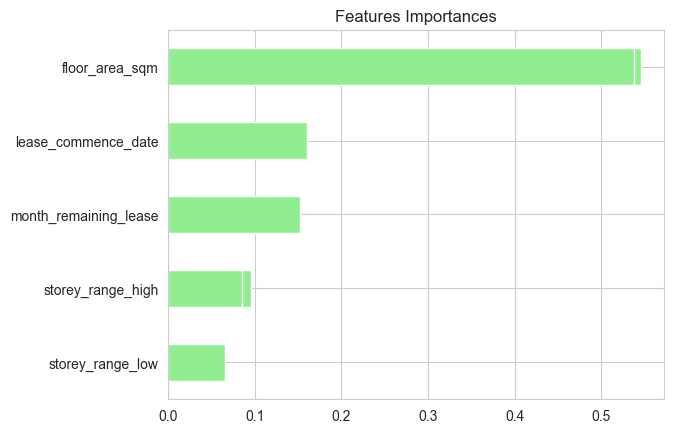

In [10]:
# decision tree algorithm to predict housing prices based on historical data

# Select features to train the model
features = ['floor_area_sqm', 'lease_commence_date', 'storey_range_low', 'storey_range_high', 'month_remaining_lease']
X = df[features]
y = df['resale_price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree regressor
regressor = DecisionTreeRegressor(random_state=42)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = regressor.predict(X_test)

# Compute and print the metrics
print("Decision Tree Performance Metrics")
print("Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {}".format(r2_score(y_test, y_pred)))

# Plot the feature importances
importances = pd.Series(data=regressor.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')

In [14]:
# Random Forest algorithm to predict housing prices based on historical data
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
regressor = RandomForestRegressor(n_estimators=25, random_state=52)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = regressor.predict(X_test)

# Compute and print the metrics
print("Random Forest Performance Metrics")
print("Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))
print("R2 score: {}".format(r2_score(y_test, y_pred)))

# Test model with new data

# Create a new data point
new_data = [[100, 2010, 1, 10, 100]]

# Predict the price of the new data point
print("Predicted price: {}".format(regressor.predict(new_data)))

Random Forest Performance Metrics
Mean Squared Error: 7206724496.52749
R2 score: 0.7417458039657219
Predicted price: [827760.]


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
